In [1]:
import pandas as pd
from path import Path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from collections import Counter

In [2]:
data = Path('Resources/dataset.csv')
df = pd.read_csv(data)
df.head()

,title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path
0,30 min Drawings,Giant Frog,kristyglas,kristyglas_30-min-drawings_giant-frog,50.0,SWAP.HIVE,PHOTO,2,False,30,2020,1,0,QmegjZDN2gyD9A6cG4efj8DwbLLGTW6isDGadNC2yVJHfH,./dataset/image/QmegjZDN2gyD9A6cG4efj8DwbLLGTW...
1,Experimental Video,Biospecimens,juliakponsford,juliakponsford_experimental-video_biospecimens,500.0,SWAP.HIVE,VIDEO,0,False,1,2020,1,0,QmeN4KuTQwHPWvGDhiopNJziqmf1feGeabDD4Gk7z9DgUL,./dataset/video/QmeN4KuTQwHPWvGDhiopNJziqmf1fe...
2,Sexy Art,long legs,badsexy,badsexy_sexy-art_long-legs,10.0,SWAP.HIVE,PHOTO,0,True,2,2021,1,0,QmaifAjZTJd8jTxNrwSoGWmFpbPYcszMF4ZcZDBwpRR4v4,./dataset/image/QmaifAjZTJd8jTxNrwSoGWmFpbPYcs...
3,Dream World,A Guide in my Dreams,yoslehz,yoslehz_dream-world_a-guide-in-my-dreams,20.0,SWAP.HIVE,PHOTO,1,False,2,2020,1,0,QmUTicJApSyByFb7sgsNa6cz8MG5RKsHvGLP61gxSF3JsN,./dataset/image/QmUTicJApSyByFb7sgsNa6cz8MG5RK...
4,Dream World,Silent Observer,yoslehz,yoslehz_dream-world_silent-observer,20.0,SWAP.HIVE,GIF,0,False,2,2020,1,0,Qmb8WbXXdorG52sgY4mSyYUjevE65SGa2vhSxdXstfinz1,./dataset/gif/Qmb8WbXXdorG52sgY4mSyYUjevE65SGa...


In [3]:
df_clean = df.drop(columns=['symbol', 'cid', 'royalty', 'path'])

In [4]:
#Filter 'Year' column from 1998 to 2021
df_cleanv2 = df_clean[df_clean['year'].between(1998,2021)]

In [5]:
df_cleanv2['age'] = (2022 - df_cleanv2['year'])

C:\Users\ariel\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
df_cleanv3 = df_cleanv2.drop(columns = ['year'])
# NSFW 1=True(NSFW) and 0=False(Safe)
df_cleanv3 ['nsfw_new'] = df_cleanv3['nsfw'].replace([False, True],[0,1])

In [7]:
nsfw_dataset = df_cleanv3.drop(columns = ['nsfw','art_series','creator','name','title','type']).astype({'price': 'int64'})
nsfw_dataset.head()

,price,likes,tokens,rights,age,nsfw_new
0,50,2,30,1,2,0
1,500,0,1,1,2,0
2,10,0,2,1,1,1
3,20,1,2,1,2,0
4,20,0,2,1,2,0


In [8]:
nsfw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4175 entries, 0 to 4188
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   price     4175 non-null   int64
 1   likes     4175 non-null   int64
 2   tokens    4175 non-null   int64
 3   rights    4175 non-null   int64
 4   age       4175 non-null   int64
 5   nsfw_new  4175 non-null   int64
dtypes: int64(6)
memory usage: 228.3 KB


In [9]:
X = nsfw_dataset.price.values.reshape(-1,1)
y = nsfw_dataset.nsfw_new

In [10]:
# Normal train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
# Use the SMOTEENN technique to perform combination sampling on the data
# Count the resampled classes
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({0: 1571, 1: 1410})

In [12]:
# Fit a Logistic regression model using random undersampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs')
model.fit(X_resampled, y_resampled)

LogisticRegression()

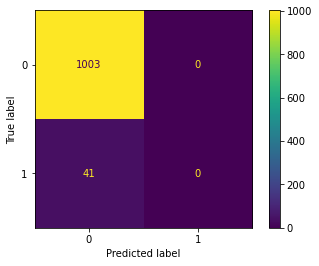

In [13]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model, X_test, y_test)  
plt.show() 

In [16]:
# Calculate the Balanced Accuracy Score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred, adjusted=False)

0.5

In [17]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      1.00      0.00      0.98      0.00      0.00      1003
          1       0.00      0.00      1.00      0.00      0.00      0.00        41

avg / total       0.92      0.96      0.04      0.94      0.00      0.00      1044

